## Pre-train Model
**EfficientNetB5**

## Image SIZE for each model
* EfficientNetB0 - (224, 224, 3)
* EfficientNetB1 - (240, 240, 3)
* EfficientNetB2 - (260, 260, 3)
* EfficientNetB3 - (300, 300, 3)
* EfficientNetB4 - (380, 380, 3)
* **EfficientNetB5 - (456, 456, 3)**
* EfficientNetB6 - (528, 528, 3)
* EfficientNetB7 - (600, 600, 3)

In [0]:
!pip install -q efficientnet

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.5) 

import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    
from copy import deepcopy as cpy

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import keras
import efficientnet.tfkeras as efn

from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras import layers

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import roc_curve,roc_auc_score, auc

SIZE = 456
BATCH_SIZE = 8

/kaggle/input
/kaggle/input/plant-pathology-2020-fgvc7
/kaggle/input/plant-pathology-2020-fgvc7/images


Using TensorFlow backend.


# Preprocessing

In [0]:
train_df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
test_df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')

train_df.shape, test_df.shape

((1821, 5), (1821, 1))

In [0]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [0]:
image_path = '/kaggle/input/plant-pathology-2020-fgvc7/images'
print('image num', len(os.listdir(image_path)))

image num 3642


In [0]:
train_df['image_id'] = train_df['image_id']+'.jpg'
test_df['image_id'] = test_df['image_id']+'.jpg'

rename class
* healthy: H
* multiple_diseases: M
* rest: R
* scab: S

In [0]:
d = {'healthy': 'H',
     'multiple_diseases': 'M',
     'rust': 'R',
     'scab': 'S'}

new_df = pd.melt(train_df, id_vars=['image_id'], var_name=['class'])
new_df['class'] = new_df['class'].apply(lambda x: d[x])
new_df.drop(np.where(new_df['value']==0)[0].tolist(), inplace=True)
new_df = new_df.groupby('image_id')['class'].sum().reset_index()
new_df.tail()

,image_id,class
1816,Train_995.jpg,R
1817,Train_996.jpg,R
1818,Train_997.jpg,S
1819,Train_998.jpg,S
1820,Train_999.jpg,R


In [0]:
train_df = pd.merge(train_df, new_df, on=['image_id'])
train_df.head(10)

,image_id,healthy,multiple_diseases,rust,scab,class
0,Train_0.jpg,0,0,0,1,S
1,Train_1.jpg,0,1,0,0,M
2,Train_2.jpg,1,0,0,0,H
3,Train_3.jpg,0,0,1,0,R
4,Train_4.jpg,1,0,0,0,H
5,Train_5.jpg,1,0,0,0,H
6,Train_6.jpg,0,1,0,0,M
7,Train_7.jpg,0,0,0,1,S
8,Train_8.jpg,0,0,0,1,S
9,Train_9.jpg,1,0,0,0,H


visualization train images

In [0]:
def display_samples(df, path, cls='None', columns=3, rows=2):
    
    fig=plt.figure(figsize=(5*columns, 4*rows))
    plt.axis('off')
    for i in range(columns*rows): 
        img = cv2.imread(os.path.join(path, df.iloc[i,:].image_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
            cls = df.iloc[i,:]['class']
        except:
            pass
        
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.grid(False)
#         plt.axis('off')
        
    plt.tight_layout()

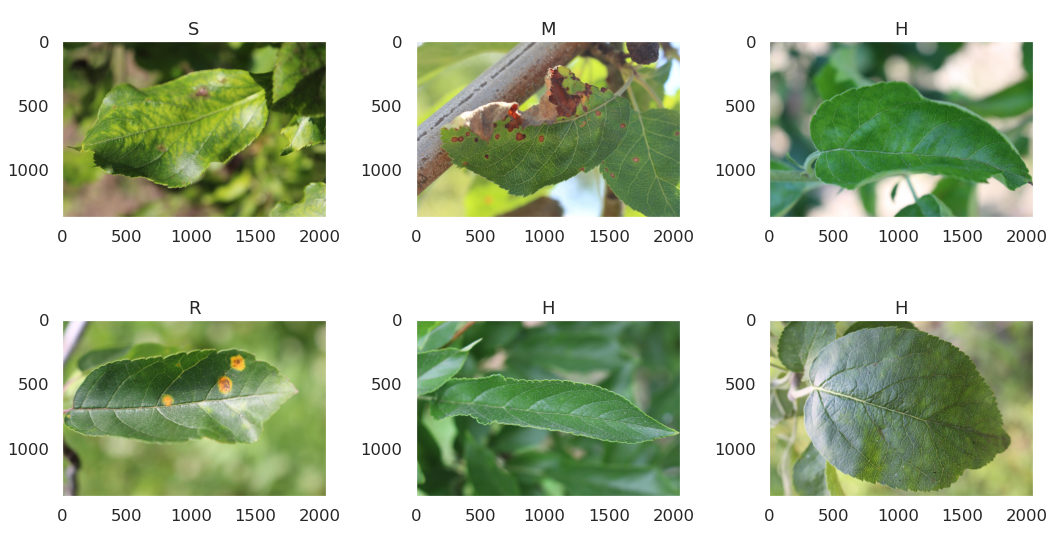

In [0]:
display_samples(train_df, image_path)

Image generator

In [0]:
def preprocess_input(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img

def train_datagen():
    return ImageDataGenerator(rescale=1./255,
                              preprocessing_function=preprocess_input,
                              rotation_range = 360,
#                               width_shift_range=0.1,
#                               height_shift_range=0.1,
#                               shear_range=0.10,
                              zoom_range=0.40,
                              fill_mode='nearest', #'constant',
#                               cval=255/2,
                              horizontal_flip=True,  # randomly flip images
                              vertical_flip=True)

def val_datagen():
    return ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

In [0]:
test_gen = val_datagen().flow_from_dataframe(dataframe=test_df,
                                                directory=image_path,
                                                x_col='image_id',
                                                y_col=None,
                                                target_size= (SIZE,SIZE),
                                                color_mode='rgb',
                                                class_mode=None,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

Found 1821 validated image filenames.


# Modeling
make baseline using 'EfficientNet-B5'

In [0]:
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.activations import elu
from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf

seed = 2019
np.random.seed(seed)
tf.random.set_seed(seed)

In [0]:
import tensorflow.keras.layers as L

effnet = efn.EfficientNetB5(input_shape=(SIZE,SIZE,3),
                            weights='imagenet',
                            include_top=False)
            
def build_model():   
    
    model = tf.keras.Sequential([effnet, 
                                 L.GlobalAveragePooling2D(), 
                                 L.Dense(4, activation="sigmoid")
                                ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=[keras.metrics.BinaryAccuracy(name='acc')])
    
    return model

115515392/115515256 [==============================] - 4s 0us/step


In [0]:
# model = build_model()
effnet.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 228, 228, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 228, 228, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

# Cross Validation

In [0]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict_proba(x))
        labels.append(y)
        
    # Flatten list of numpy arrays
    return np.concatenate(preds), np.concatenate(labels)


def get_callback(model_name, patient=10, mode='min'):
    ES = EarlyStopping(
                        monitor='val_loss', 
                        patience=patient, 
                        mode=mode, 
                        verbose=1)
    
    RR = ReduceLROnPlateau(
                        monitor = 'val_loss', 
                        factor = 0.3, 
                        patience = patient//2, 
                        min_lr=0.00001, 
                        verbose=1, 
                        mode=mode)
    
    MC = ModelCheckpoint(
                        filepath=model_name, 
                        monitor='val_loss', 
                        verbose=1, 
                        save_best_only=True)

    return [ES, RR, MC]


# about ROC-AUC metric is 
# https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
class RocCallback(Callback):
    def __init__(self, model_name, val_gen):
        self.model_name=model_name
        self.val_gen=val_gen
    
    def on_train_begin(self, logs={}):
        self.val_auc=[]
        
    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets ROC-AUC score on the validation data
        """
        # Get predictions and labels
        y_pred, labels = get_preds_and_labels(self.model, self.val_gen)
        
        _val_auc = roc_auc_score(labels, y_pred, average="macro")
        self.val_auc.append(_val_auc)
        
        print(f"val_auc: {round(_val_auc, 4)}")
        
        if _val_auc == max(self.val_auc):
            print(f"ROC-AUC score has improved. Saving model to {self.model_name}.")
            self.model.save(self.model_name)
            
        return   

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [0]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, random_state=2048)

In [0]:
models, hilist = [], []

for i, (train_idx, valied_idx) in enumerate(skf.split(train_df['image_id'], train_df['class'])):
    
    X_train = train_df.iloc[train_idx, :].reset_index()
    X_val = train_df.iloc[valied_idx, :].reset_index()
    
    train_gen = train_datagen().flow_from_dataframe(dataframe=X_train,
                                                    directory=image_path,
                                                    x_col='image_id',
                                                    y_col=['healthy','multiple_diseases','rust','scab'],
                                                    target_size= (SIZE,SIZE),
                                                    color_mode='rgb',
                                                    class_mode='raw',
                                                    batch_size=BATCH_SIZE,
                                                    seed=2048,
                                                    shuffle=True)
    
    val_gen = val_datagen().flow_from_dataframe(dataframe=X_val,
                                                    directory=image_path,
                                                    x_col='image_id',
                                                    y_col=['healthy','multiple_diseases','rust','scab'],
                                                    target_size= (SIZE,SIZE),
                                                    color_mode='rgb',
                                                    class_mode='raw',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False)

    model_name = 'model_{}.h5'.format(i+1)
    models.append(model_name)
    
    model = build_model()
    
    roc = RocCallback(model_name, val_gen)
    
    print(f"\nModel{i} Start")
    history = model.fit_generator(train_gen,
                                  steps_per_epoch=len(X_train)/BATCH_SIZE,
                                  epochs=25,
                                  validation_data=val_gen, 
                                  validation_steps=len(X_val)/BATCH_SIZE,
                                  verbose=1,
                                  callbacks=[roc] +get_callback(model_name, patient=6))
    hilist.append(history)

    del model
    K.clear_session()
    

Found 1456 validated image filenames.
Found 365 validated image filenames.

Model0 Start
Train for 182.0 steps, validate for 45.625 steps
Epoch 1/25
181/182 [============================>.] - ETA: 1s - loss: 0.3009 - acc: 0.8513val_auc: 0.9143
ROC-AUC score has improved. Saving model to model_1.h5.

Epoch 00001: val_loss improved from inf to 0.63330, saving model to model_1.h5
182/182 [==============================] - 257s 1s/step - loss: 0.2995 - acc: 0.8515 - val_loss: 0.6333 - val_acc: 0.8836
Epoch 2/25
181/182 [============================>.] - ETA: 0s - loss: 0.2039 - acc: 0.8939val_auc: 0.9016

Epoch 00002: val_loss improved from 0.63330 to 0.25295, saving model to model_1.h5
182/182 [==============================] - 218s 1s/step - loss: 0.2030 - acc: 0.8940 - val_loss: 0.2529 - val_acc: 0.9025
Epoch 3/25
181/182 [============================>.] - ETA: 0s - loss: 0.1741 - acc: 0.9102val_auc: 0.9346
ROC-AUC score has improved. Saving model to model_1.h5.

Epoch 00003: val_loss i

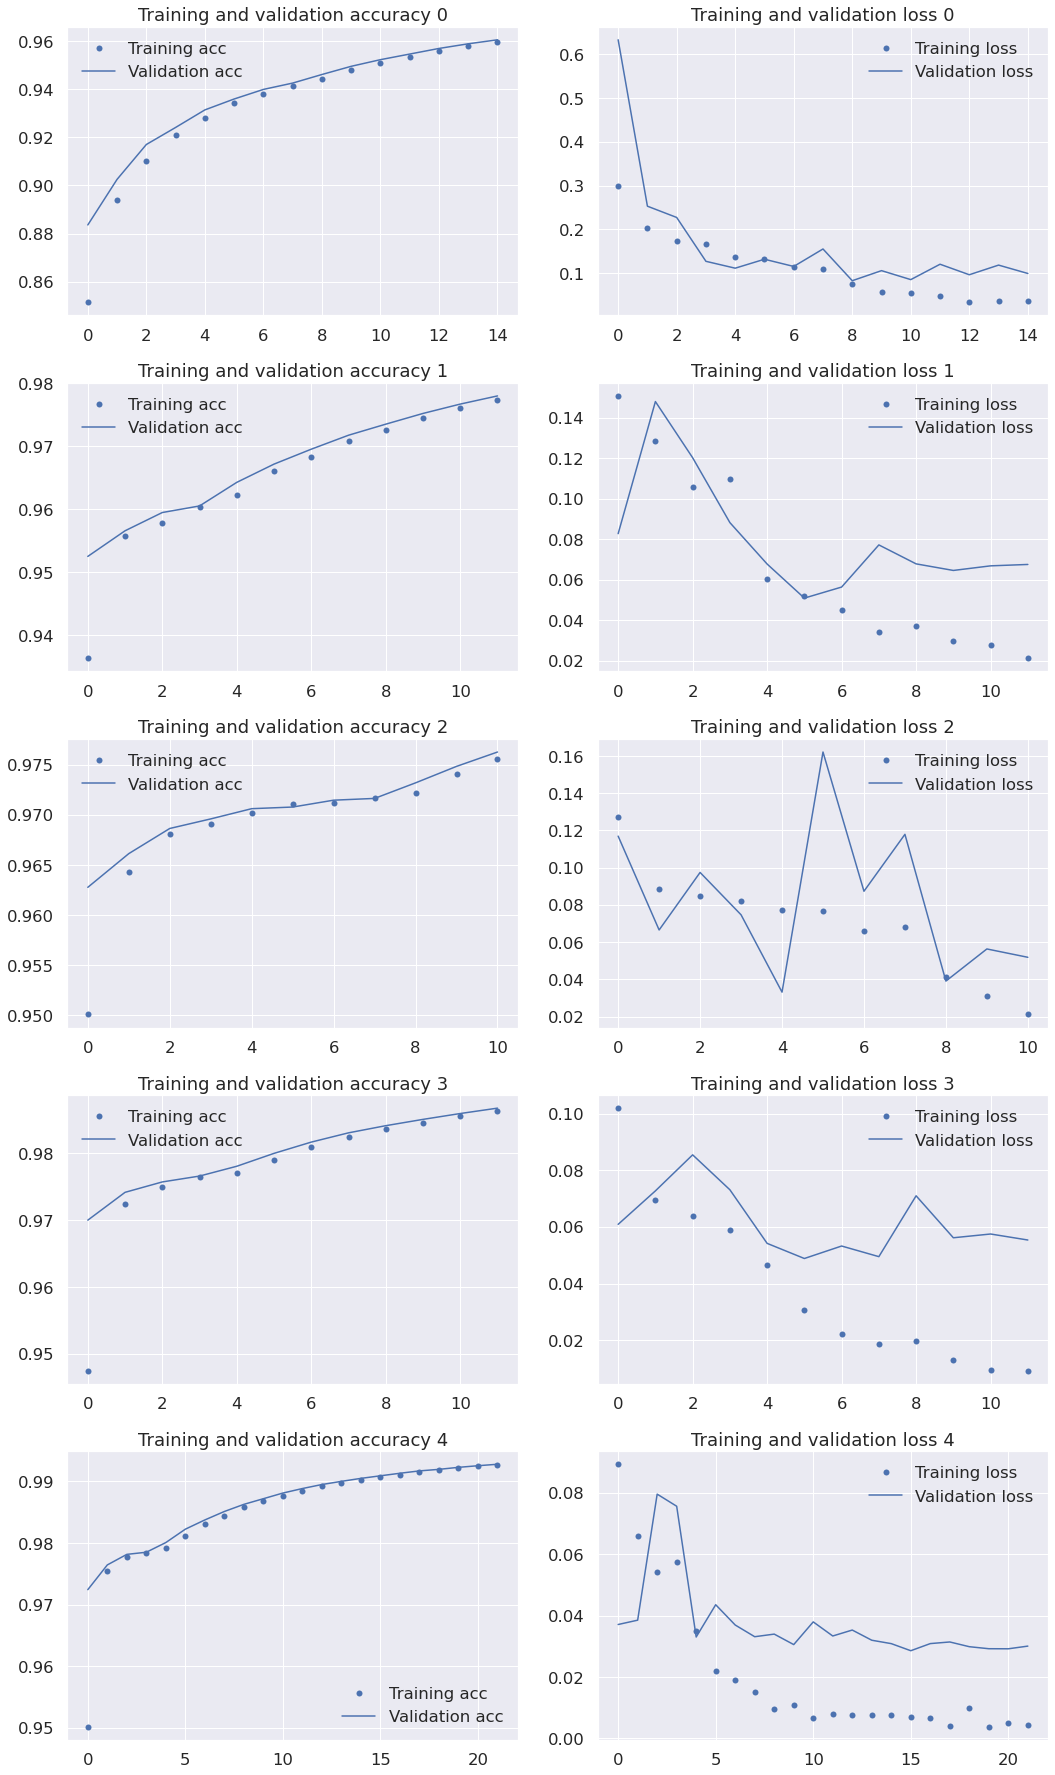

In [0]:
fig=plt.figure(figsize=(15, 25))

for i in range(5): 
    acc = hilist[i].history['acc']
    val_acc = hilist[i].history['val_acc']
    loss = hilist[i].history['loss']
    val_loss = hilist[i].history['val_loss']

    epochs = range(len(acc))
    
    fig.add_subplot(5, 2, 2*i+1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(f'Training and validation accuracy {i}')
    plt.legend()
    
    fig.add_subplot(5, 2, 2*(i+1))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss {i}')
    plt.legend()

plt.tight_layout()

**the ROC-AUC score**

In [0]:
model = build_model()
test_predictions, test_labels = [], []
for i, name in enumerate(models):
    model.load_weights(name)
    val_gen.reset()
    p, la = get_preds_and_labels(model, val_gen)
    test_predictions.append(p)
    test_labels.append(la)
    

In [0]:
class_name = train_df.columns[1:-1]
class_name

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [0]:
mean_score = 0
for m in range(5):
    test_label = test_labels[m]
    test_predictions_baseline = test_predictions[m]
    score = roc_auc_score(test_label, test_predictions_baseline, average="macro")
    mean_score += score
    print(f'Model{m} categorical classifier ROC AUC: {score}')
    
print('mean ROC-AUC score', mean_score/5)

Model0 categorical classifier ROC AUC: 0.9971534214204881
Model1 categorical classifier ROC AUC: 0.9970140455724001
Model2 categorical classifier ROC AUC: 0.9934025761563894
Model3 categorical classifier ROC AUC: 0.999951246328374
Model4 categorical classifier ROC AUC: 0.9957358539004105
mean ROC-AUC score 0.9966514286756125


In [0]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

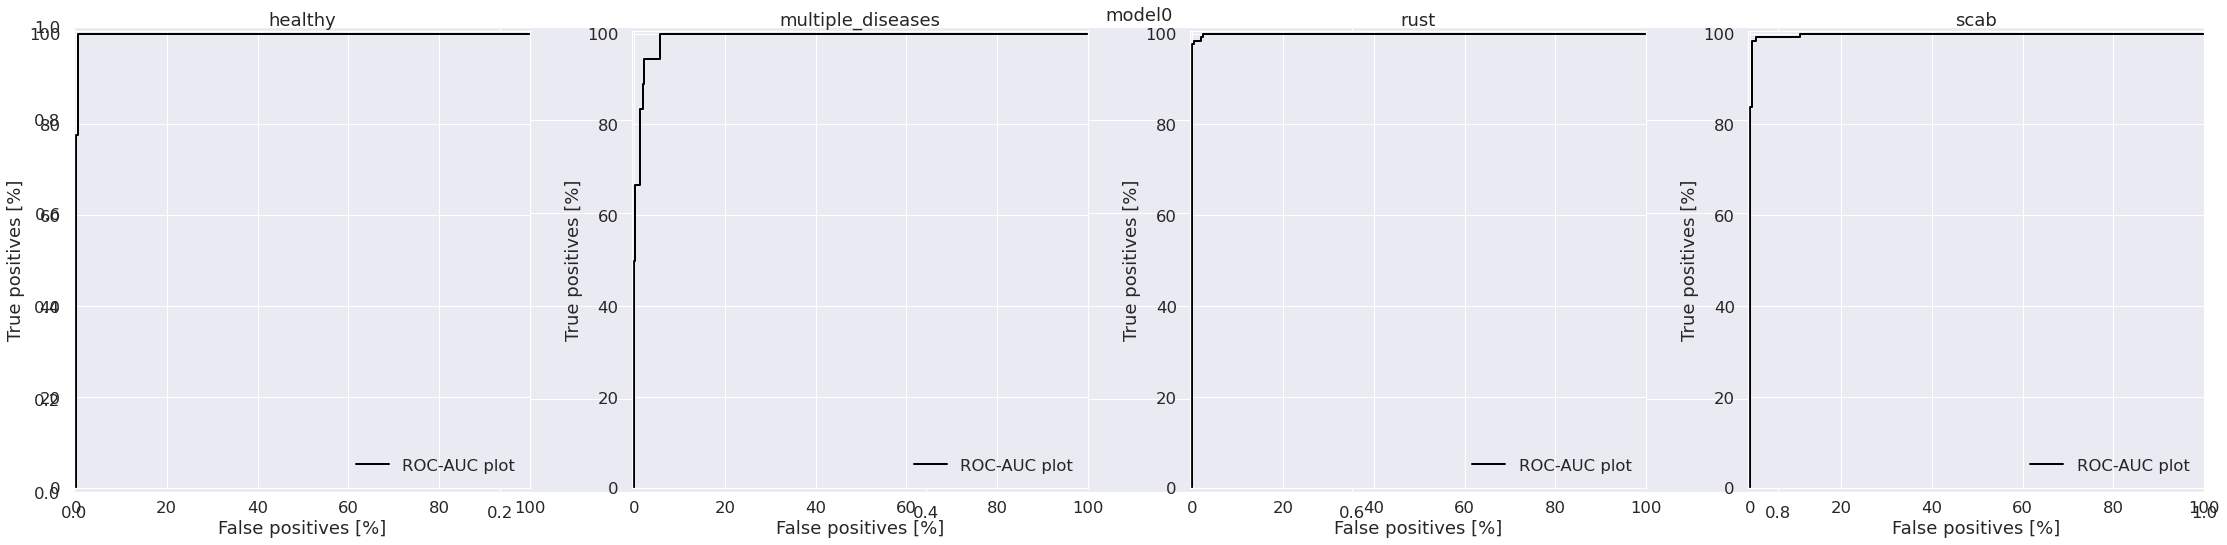

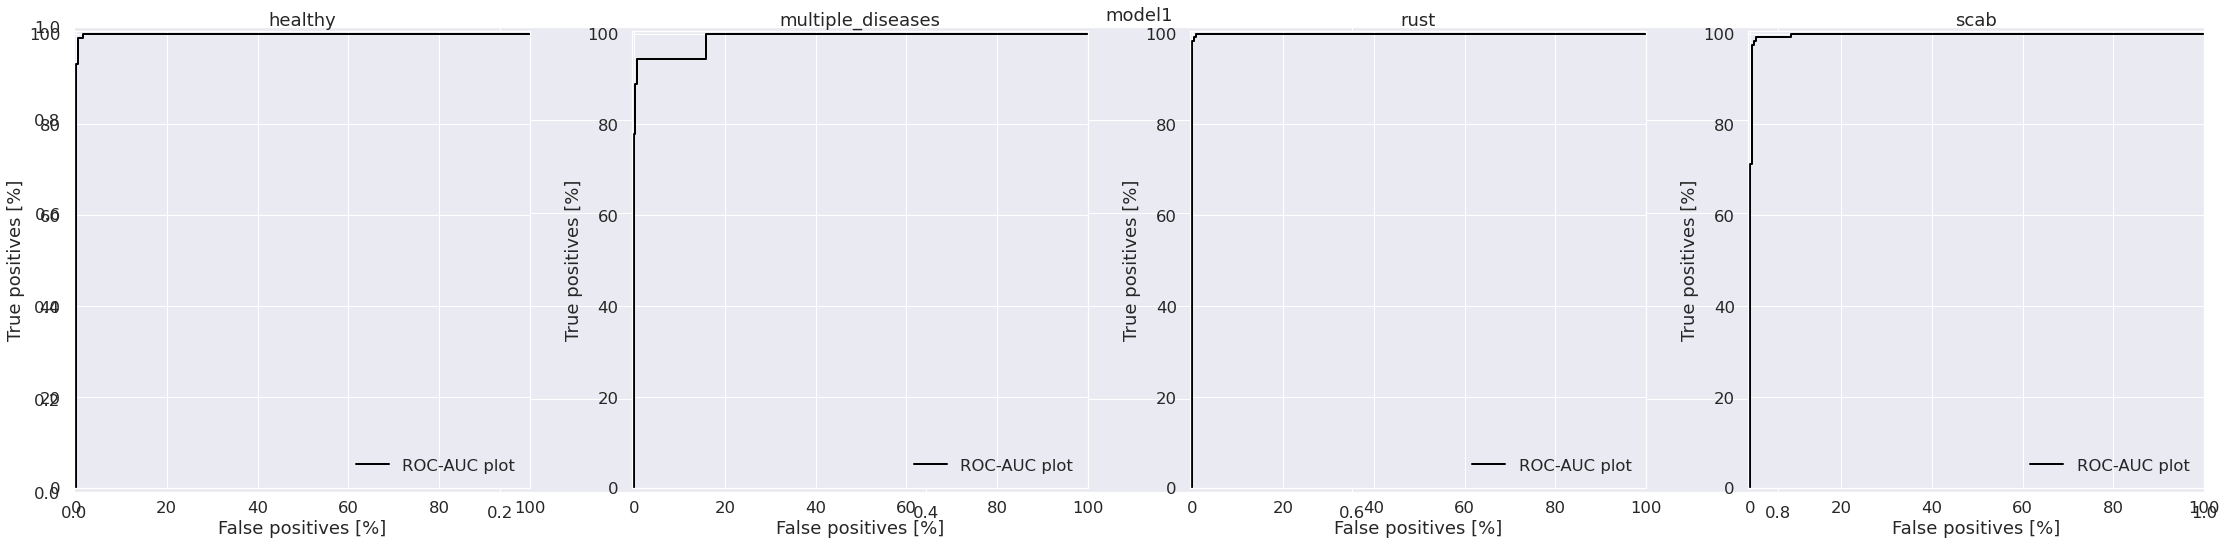

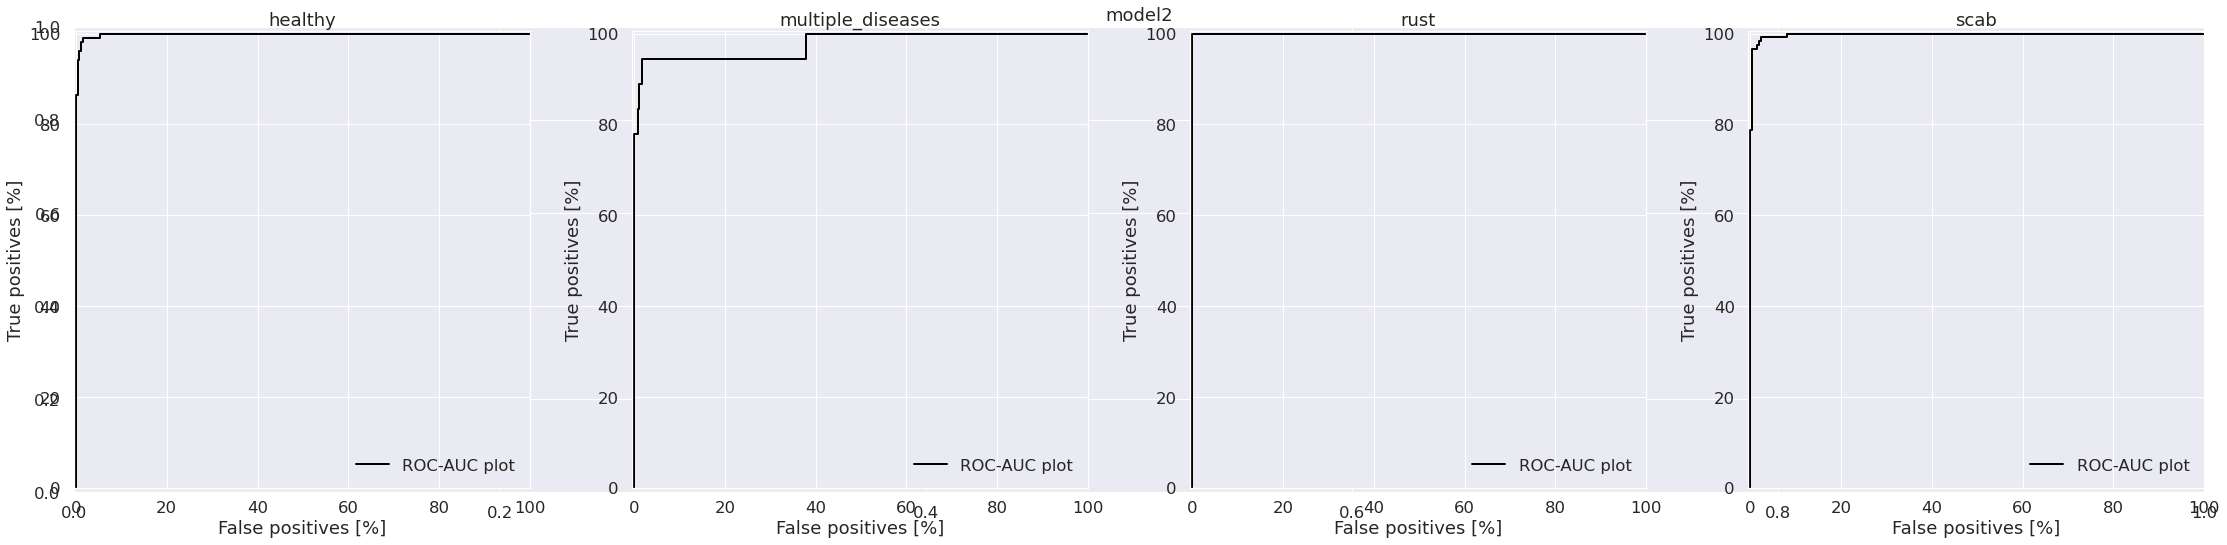

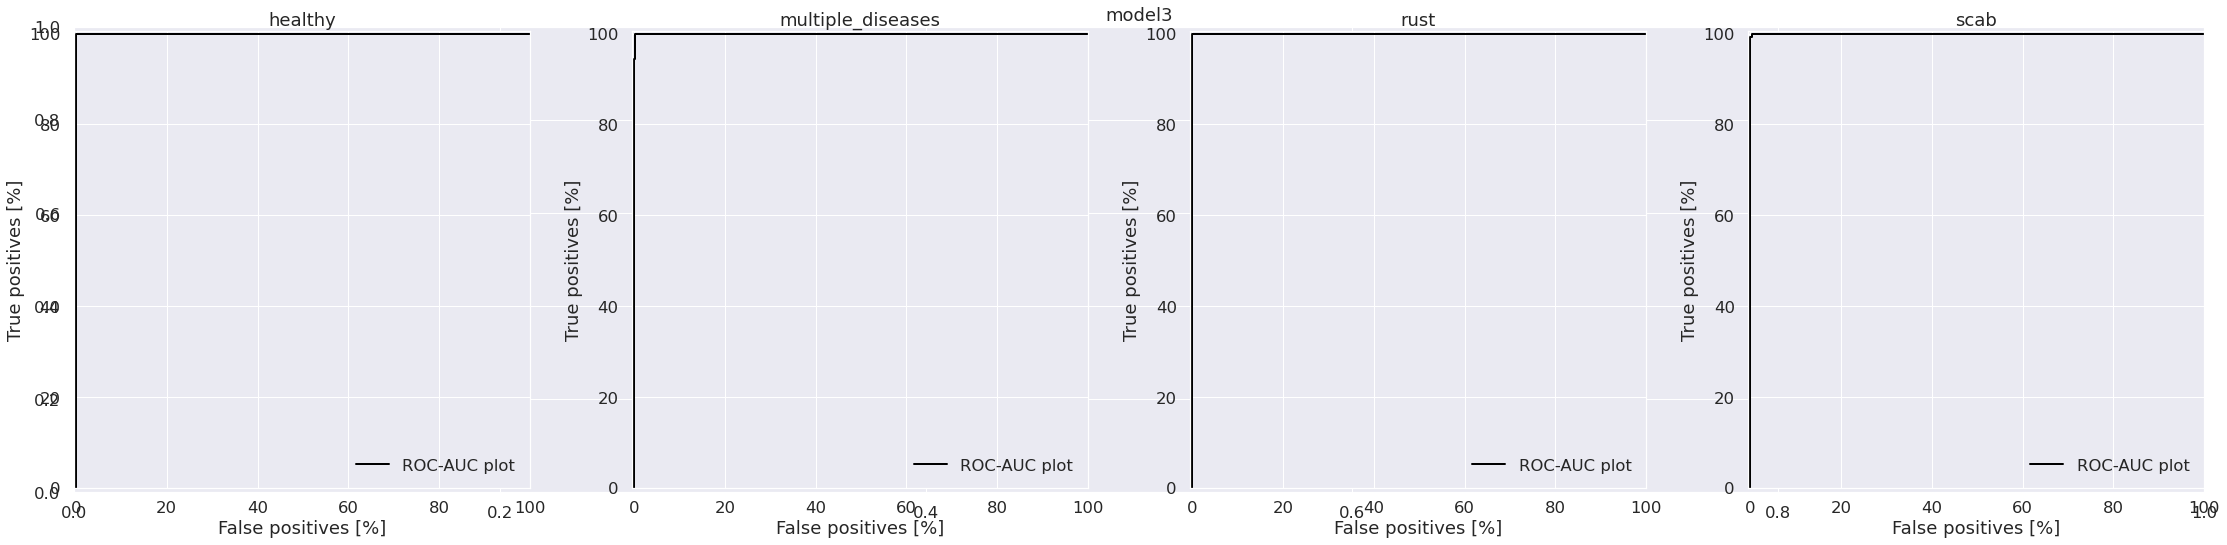

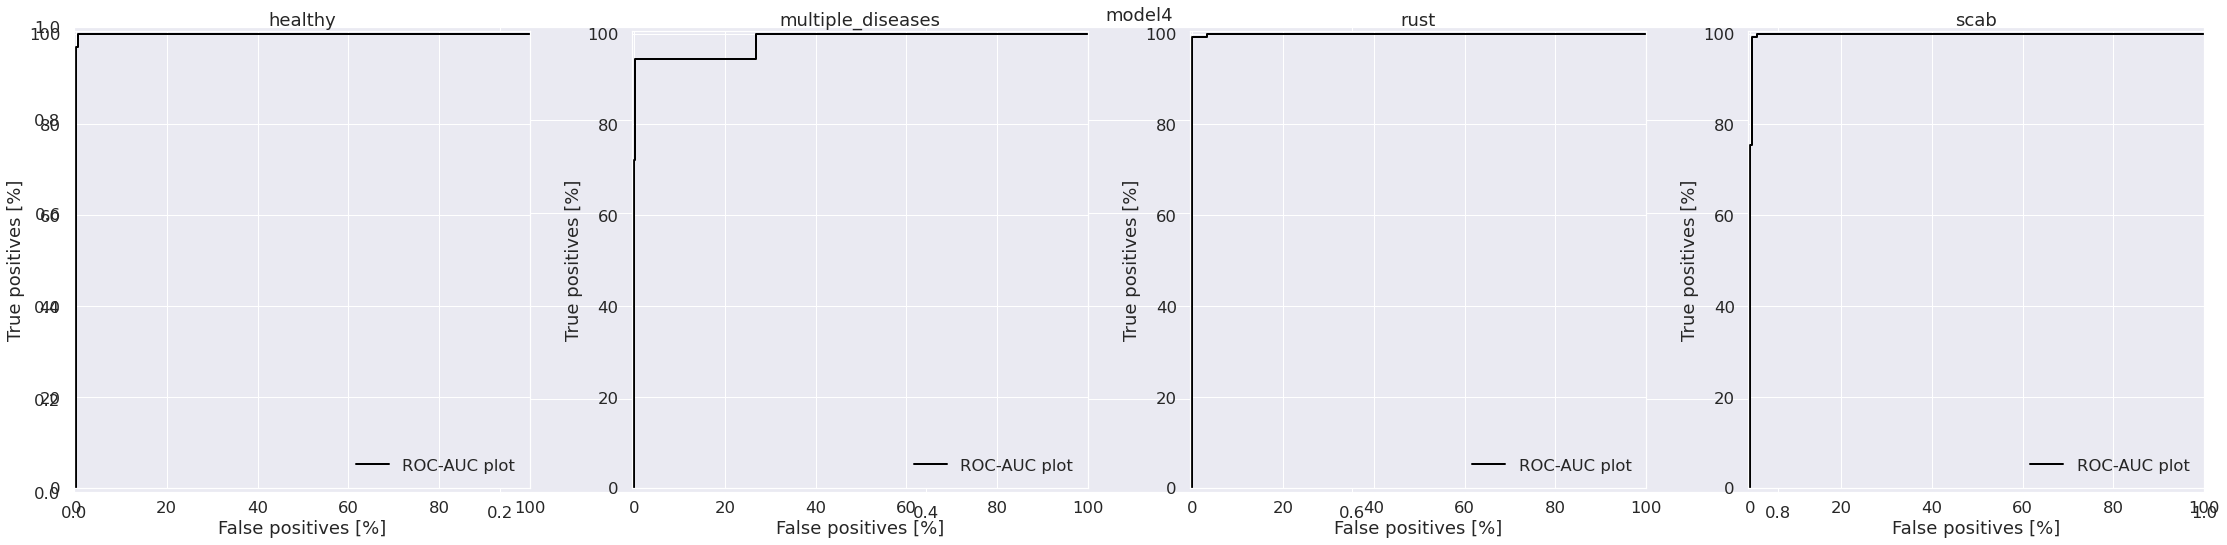

In [0]:
columns, rows = 4, 1
for m in range(5):
    test_label = test_labels[m]
    test_predictions_baseline = test_predictions[m]
    
    fig=plt.figure(figsize=(8*columns, 8*rows))
    plt.title(f'model{m}')
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plot_roc("ROC-AUC plot", test_label[:,i], test_predictions_baseline[:,i], color='black')
        plt.title(class_name[i])
        plt.legend(loc='lower right')
    plt.tight_layout()

ROC 곡선의 AUC가 0.5. 이는 임의 양성 예제가 임의 음성 예제보다 높은 순위일 확률이 50%임을 의미합니다. 따라서 해당하는 분류 모델의 예측 능력이 임의 추측보다 낫지 않으므로 이 모델은 기본적으로 가치가 없습니다.

ROC 곡선의 AUC가 0.5~1.0이어야 함. FP < TP인 곡선 모양. 이는 임의 양성 예제가 임의 음성 예제보다 상위일 확률이 50% 이상이라는 의미. 실제 이진 분류 AUC 값은 대개 이 범위에 속함.

위 곡선에서는 모든 양성 예측이 모든 음성 예측보다 상위에 있으므로 최선의 ROC 곡선. 곡선의 AUC는 1.0. but, 실제로 AUC가 1.0인 '완벽한' 분류자가 있다면 모델에 버그가 있다는 의미일 수 있으므로 의심해 보아야 합니다. 예를 들어 학습 데이터에 과적합 데이터가 있거나 특징 중 하나에서 라벨 데이터가 중복되었을 수 있습니다.

# Ensemble

In [0]:
sub = pd.read_csv("../input/plant-pathology-2020-fgvc7/sample_submission.csv")
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [0]:
predictions = []
# model = build_model()
for i, name in enumerate(models):
    model.load_weights(name)
    y_pred = model.predict(test_gen, verbose=1)
    y_pred = y_pred.clip(0,1)
    predictions.append(y_pred)
    test_gen.reset()
    
y_test = np.mean(predictions, axis=0)
y_test[:10]

228/228 [==============================] - 79s 344ms/step


array([[6.3756260e-04, 6.2945718e-03, 9.9665260e-01, 5.0417357e-04],
       [9.9950448e-05, 1.3804693e-03, 9.9941909e-01, 3.5731704e-04],
       [5.9630082e-05, 9.0752461e-04, 7.1510876e-05, 9.9947774e-01],
       [9.9955606e-01, 6.4907118e-04, 3.5844854e-04, 8.1641461e-05],
       [3.6280271e-05, 1.3041243e-04, 9.9991304e-01, 8.1516177e-05],
       [9.9833524e-01, 2.7828792e-03, 1.0266301e-03, 2.8712591e-04],
       [9.9651372e-01, 2.5598586e-03, 1.2694820e-03, 4.9599301e-04],
       [8.0638943e-05, 2.0647878e-03, 1.8838554e-04, 9.9771726e-01],
       [1.4121506e-03, 5.8145143e-02, 3.3141873e-03, 9.6920919e-01],
       [2.1689286e-05, 1.7665850e-03, 9.9986362e-01, 4.7776870e-05]],
      dtype=float32)

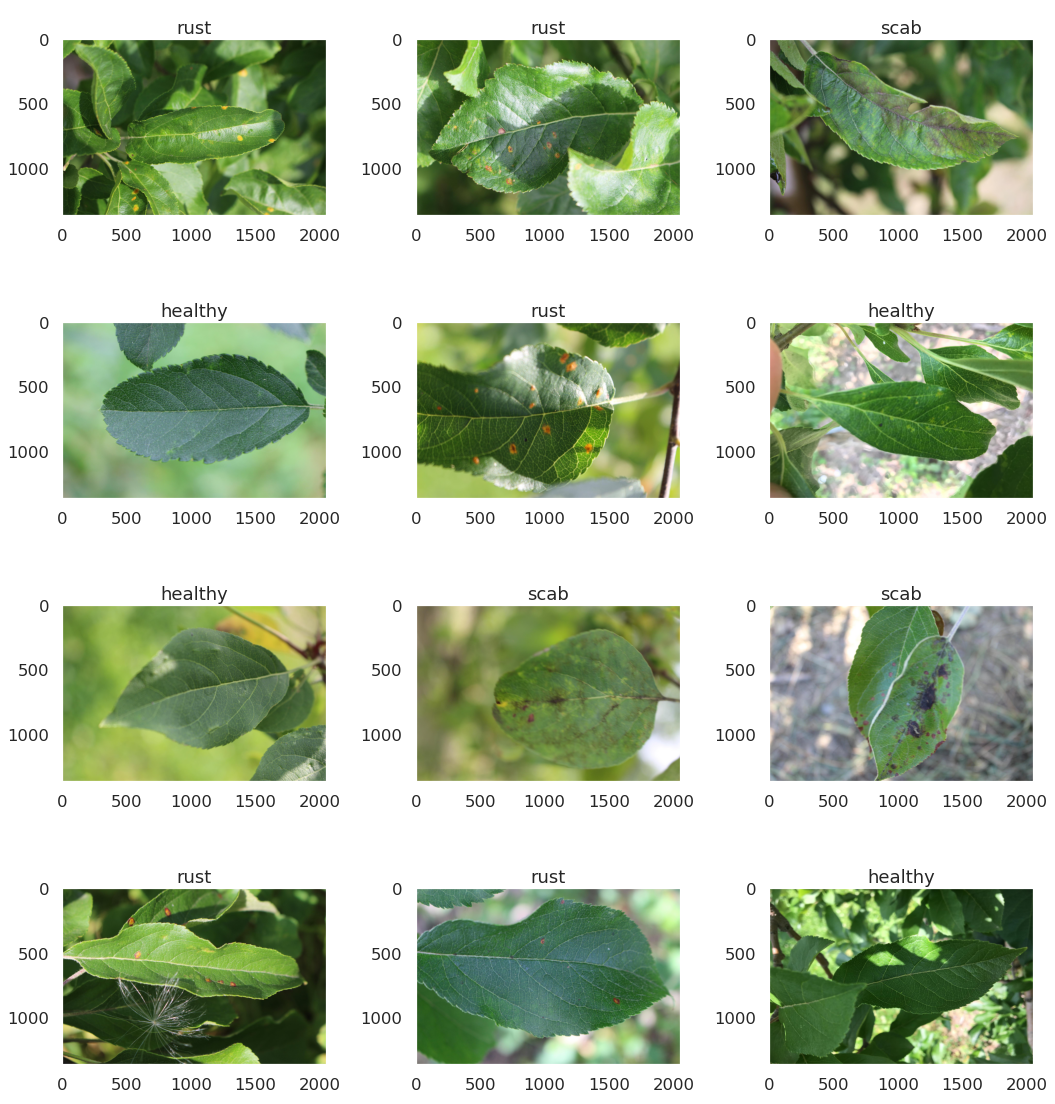

In [0]:
class_test = [class_name[x] for x in np.argmax(y_test, axis=1)]
test_df['class'] = class_test
display_samples(test_df, image_path, columns=3, rows=4) # test_path

In [0]:
sub.iloc[:, 1:] = y_test
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000638,0.006295,0.996653,0.000504
1,Test_1,0.000100,0.001380,0.999419,0.000357
2,Test_2,0.000060,0.000908,0.000072,0.999478
3,Test_3,0.999556,0.000649,0.000358,0.000082
4,Test_4,0.000036,0.000130,0.999913,0.000082


In [0]:
sub.to_csv('efn_cv_submission.csv', index=False)